# ML to Predict Planetary Stability
One key question planetary scientists strive to understand is the longterm stability of exoplanetary systems. That is, they would like to know whether, over billions of orbits, planets will collide or be ejected from the system. Due to the [chaotic](https://en.wikipedia.org/wiki/Chaos_theory) nature of planetary systems, the "answer" of whether a particular planetary system is longterm stable can only be explored statistically. For example, [Laskar & Gastineau (2009)](https://www.nature.com/articles/nature08096) researched the longterm stability of the Solar System by performing 2,501 N-body simulations, each 5 Gyr, and found that one per cent of the solutions lead to a large unstable increase in Mercury’s eccentricity. However, this study would have taken roughly **200 years** to complete on a standard workstation (they had access to a very large computing cluster), motivating the exploration of other methods to speed the process. 

One such method is to use machine learning to predict the longterm behaviour of a planetary system based off its early evolution. Once the model is trained, it can take as little as a second to generate new predictions, arriving at an answer quickly. Such a method is described and presented in [Tamayo, Silburt, et al. (2016)](https://arxiv.org/abs/1610.05359). In this notebook, we will explore a simplified version of this work, using a dataset of 25,000 simulated 3-planet systems to train and test a variety of machine learning models.

In [174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import precision_recall_curve, roc_curve
pd.options.mode.chained_assignment = None

First, let's load the raw initial conditions for each system, using ```pandas```. For each of the three planets (identified ```1```, ```2```, ```3```):  
- ```a``` = $a$ = semi-major axis.  
- ```e``` = $e$ = eccentricity.  
- ```omega``` = $\omega$ = argument of periapsis.
- ```Omega``` = $\Omega$ = Longitude of ascending node.
- ```inc``` = $i$ = inclination.  
- ```m``` = $m$ = planet mass.
- ```true_anom``` = $\nu$ = true anomaly.
- ```mean_anom``` = $M$ = mean anomaly.

In addition:
- ```runstring``` = identifier for each simulation. 

In [82]:
df = pd.read_csv('Stability_Data_inial_conditions.csv', index_col=0)
df.tail()

,runstring,a1,e1,omega1,inc1,m1,Omega1,true_anom1,mean_anom1,a2,...,mean_anom2,a3,e3,omega3,inc3,m3,Omega3,true_anom3,mean_anom3,Stable
24995,0024995.bin,1.0,0.001983,-0.103719,0.034756,6.384047e-07,1.891501,2.323505,2.320607,1.171907,...,2.707954,1.387978,0.136176,2.998349,0.013797,0.000001,-1.687570,-0.102447,-0.077197,0.0
24996,0024996.bin,1.0,0.000435,-0.528805,0.009183,4.383173e-06,-1.320371,2.943623,2.943452,1.118284,...,-2.457528,1.220488,0.000275,2.799539,0.006669,0.000033,-0.174781,-4.296110,1.986572,0.0
24997,0024997.bin,1.0,0.000159,0.995542,0.001832,3.176214e-05,1.857300,0.520523,0.520365,1.579004,...,-2.851285,1.697671,0.014659,0.939074,0.090331,0.000011,-2.313583,1.605318,1.576007,0.0
24998,0024998.bin,1.0,0.042915,2.803428,0.034103,4.817579e-07,0.320698,-2.821058,-2.793167,1.055424,...,1.879639,1.286817,0.002571,-1.435588,0.002550,0.000011,-0.858794,1.509610,1.504478,0.0
24999,0024999.bin,1.0,0.000022,-0.388908,0.019481,4.806837e-05,0.756854,2.089563,2.089526,1.316695,...,0.100434,1.849302,0.001253,-2.367310,0.005140,0.000041,-0.267279,0.119263,0.118965,1.0


For reference, the orbital elements are shown here:
![title](555px-Orbit1.svg.png)

## Plotting
Let's plot the data to get a sense of what it looks like.

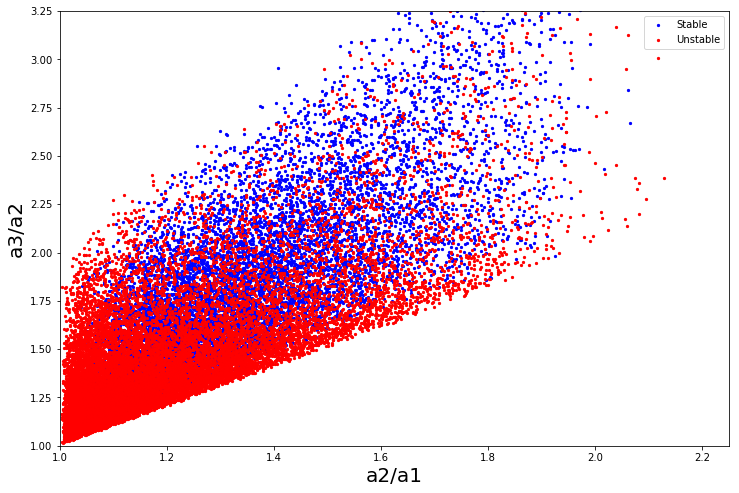

In [88]:
x = df['a2'].values/df['a1'].values
y = df['a3'].values/df['a1'].values

fig, ax = plt.subplots(figsize=(12,8))
stable = df['Stable'] == 1
unstable = df['Stable'] == 0
ax.scatter(x[stable], y[stable], color='blue', s=5, label='Stable')
ax.scatter(x[unstable], y[unstable], color='red', s=5, label='Unstable')

ax.set_xlim([1,2.25])
ax.set_ylim([1,3.25])
ax.set_xlabel('a2/a1', fontsize=20)
ax.set_ylabel('a3/a2', fontsize=20)
ax.legend()

## Get Input and Target

In [176]:
# output target
y = df['Stable']

cols = df.columns[1:-2]  
X = df[cols]
X.head()

,a1,e1,omega1,inc1,m1,Omega1,true_anom1,mean_anom1,a2,e2,...,Omega2,true_anom2,mean_anom2,a3,e3,omega3,inc3,m3,Omega3,true_anom3
0,1.0,0.005031,1.400202,0.008978,3.414016e-05,1.770839,-1.534327,-1.524274,1.221502,0.059391,...,1.573978,-0.567081,-0.505606,1.589043,0.002515,1.084278,0.065498,1.826900e-06,-1.192440,-0.614709
1,1.0,0.010350,-2.070391,0.001541,2.529838e-07,-1.493638,0.013233,0.012961,1.190647,0.013048,...,-1.749616,1.437355,1.411526,1.671403,0.072450,0.275475,0.046939,1.955797e-05,-0.619350,0.192203
2,1.0,0.051912,-1.710828,0.016289,7.380789e-05,2.705977,2.472633,2.406234,1.125660,0.042326,...,-0.032550,-0.317958,-0.292271,1.936762,0.003395,0.624064,0.014535,1.477931e-07,2.795101,1.685406
3,1.0,0.000152,-2.300890,0.003301,5.174804e-07,-1.027543,2.993015,2.992970,1.216684,0.000026,...,0.946351,-2.294238,-2.294199,1.503164,0.057380,2.166845,0.098014,1.287851e-06,-2.995941,-1.625763
4,1.0,0.001457,0.653565,0.033910,5.106746e-07,1.084883,0.667169,0.665367,1.034058,0.020334,...,-0.455684,-1.074927,-1.039417,1.059346,0.010325,0.038984,0.011840,1.542321e-06,-1.253823,1.215392


## Feature Engineering

In [177]:
X['Rhill_12'] = 0.5*(X['a1'] + X['a2'])*((X['m1'] + X['m2'])/3.)**(1./3.)
X['Rhill_23'] = 0.5*(X['a3'] + X['a2'])*((X['m3'] + X['m2'])/3.)**(1./3.)
X.head()

,a1,e1,omega1,inc1,m1,Omega1,true_anom1,mean_anom1,a2,e2,...,mean_anom2,a3,e3,omega3,inc3,m3,Omega3,true_anom3,Rhill_12,Rhill_23
0,1.0,0.005031,1.400202,0.008978,3.414016e-05,1.770839,-1.534327,-1.524274,1.221502,0.059391,...,-0.505606,1.589043,0.002515,1.084278,0.065498,1.826900e-06,-1.192440,-0.614709,0.028916,0.026716
1,1.0,0.010350,-2.070391,0.001541,2.529838e-07,-1.493638,0.013233,0.012961,1.190647,0.013048,...,1.411526,1.671403,0.072450,0.275475,0.046939,1.955797e-05,-0.619350,0.192203,0.024868,0.037600
2,1.0,0.051912,-1.710828,0.016289,7.380789e-05,2.705977,2.472633,2.406234,1.125660,0.042326,...,-0.292271,1.936762,0.003395,0.624064,0.014535,1.477931e-07,2.795101,1.685406,0.038585,0.043732
3,1.0,0.000152,-2.300890,0.003301,5.174804e-07,-1.027543,2.993015,2.992970,1.216684,0.000026,...,-2.294199,1.503164,0.057380,2.166845,0.098014,1.287851e-06,-2.995941,-1.625763,0.012972,0.016725
4,1.0,0.001457,0.653565,0.033910,5.106746e-07,1.084883,0.667169,0.665367,1.034058,0.020334,...,-1.039417,1.059346,0.010325,0.038984,0.011840,1.542321e-06,-1.253823,1.215392,0.006304,0.008739


## Split into Train/Test data

In [105]:
# use subset of data - don't need 25,000 for initial model building
frac_data = 0.5

# randomly split into train/test data
trainN = 0.8
testN = 0.2
N = int(len(X)*frac_data)

# build training/test datasets
rN = np.arange(0,N)
np.random.shuffle(rN)
train_i, test_i = rN[0: int(trainN*N)], rN[int(trainN*N):]
Xtrain, Xtest = X.iloc[train_i], X.iloc[test_i]
ytrain, ytest = y.iloc[train_i], y.iloc[test_i]

## Logistic Regression
http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [167]:
from sklearn.linear_model import LogisticRegression
fold = KFold(n_splits=3, shuffle=False, random_state=None)
grid = {
    'C': [1],
    'solver': ['newton-cg']
}
clf = LogisticRegression(penalty='l2', random_state=777, max_iter=10000, tol=10)

# Search over grid
gs = GridSearchCV(clf, grid, scoring='roc_auc', cv=fold)

In [168]:
# perform grid search, might take a minute!
gs.fit(Xtrain, ytrain)
print ('gs.best_score_:', gs.best_score_)
print ('gs.best_params_:', gs.best_params_)

gs.best_score_: 0.873235235095
gs.best_params_: {'C': 1, 'solver': 'newton-cg'}


In [120]:
# Load and train best model
LR_best = LogisticRegression(C=gs.best_params_['C'], solver=gs.best_params_['solver'],
                          penalty='l2', random_state=777, max_iter=10000, tol=10)
LR_best.fit(Xtrain, ytrain)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=777, solver='newton-cg', tol=10,
          verbose=0, warm_start=False)

In [165]:
def PR_ROC_curve(model, Xtest, ytest):
    ypred = model.predict_proba(Xtest)
    precision, recall, thresholds = precision_recall_curve(ytest, ypred[:,1])
    fpr, tpr, thresholds = roc_curve(ytest, ypred[:,1])
    auc = metrics.roc_auc_score(ytest, ypred[:,1])
    
    f, ax = plt.subplots(1, 2, figsize=(15,6))
    ax[0].plot(recall, precision, label='auc=%f'%auc)
    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.0])
    ax[0].set_xlabel('Recall',fontsize=12)
    ax[0].set_ylabel('Precision',fontsize=12)
    ax[0].set_title("Precision-Recall Curve")
    ax[0].legend()
    
    ax[1].plot(fpr, tpr)
    ax[1].plot([0, 1], [0, 1], 'k--')
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlabel('False Positive Rate')
    ax[1].set_ylabel('True Positive Rate')
    ax[1].set_title("Receiver Operating Characteristic Curve")

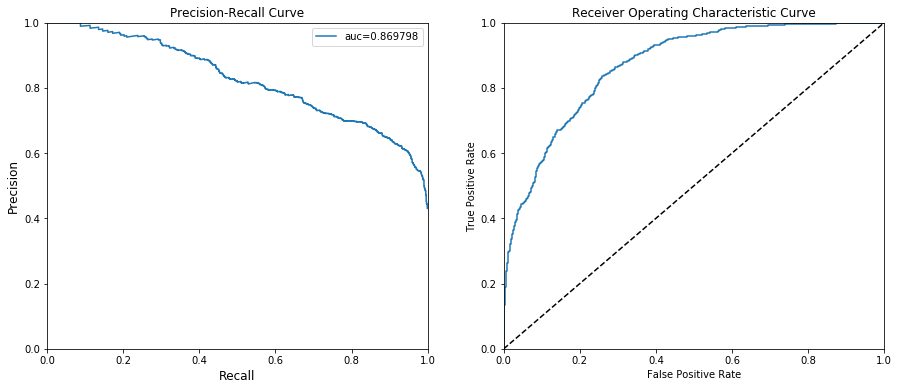

In [166]:
# Get statistics to measure performance
PR_ROC_curve(LR_best, Xtest, ytest)

# To do:
- A few more algorithms  
- More explanations of everything
- Flesh out grid search for Logistic Regression
- Gold standard in all PR/ROC curves.